In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import pandas as pd
import json
from statistics import mean
from statsmodels.tsa.stattools import grangercausalitytests
import datetime as dt
from datetime import datetime, timedelta, date
import torch
from torch import nn
from pyro.nn import PyroModule
from pyro.infer import Predictive

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [2]:
%matplotlib inline
plt.style.use('default')

In [3]:
# read in data
companies = [('AMZN', 'Amazon'), ('AAPL', 'Apple'), ('MSFT', 'Microsoft'),
             ('DIS', 'Disney'), ('GOOG', 'Google'), ('CVS', 'CVS'),
             ('GE', 'General Electric'), ('SAN', 'Santander'),
             ('GS', 'Goldman Sachs'), ('CICHY', 'China Construction Bank')]
stock_data = []
tweet_data = []
n = 1 # usually would be equal to len(companies), but we are testing on a sample (i.e., just Amazon)
for company in companies:
    abbr = company[0]
    curr_stock = pd.read_csv('./COMS6998-Project/financial/' + abbr + '_financial.csv')
    del curr_stock['Unnamed: 0']
    stock_data.append(curr_stock)
    curr_tweet = pd.read_csv('COMS6998-Project/sentiment/' + abbr + '_sentiment.csv')
    times = []
    for time in curr_tweet['Time']:
        date = time.split()[0]
        times.append(date)
    curr_tweet['Time'] = times
    del curr_tweet['Unnamed: 0']
    del curr_tweet['Unnamed: 0.1']
    tweet_data.append(curr_tweet)

In [4]:
# sample stock data for Amazon
stock_data[0].head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-12-31,1510.800049,1520.760010,1487.000000,1501.969971,1501.969971,6954500
1,2019-01-02,1465.199951,1553.359985,1460.930054,1539.130005,1539.130005,7983100
2,2019-01-03,1520.010010,1538.000000,1497.109985,1500.280029,1500.280029,6975600
3,2019-01-04,1530.000000,1594.000000,1518.310059,1575.390015,1575.390015,9182600
4,2019-01-07,1602.310059,1634.560059,1589.189941,1629.510010,1629.510010,7993200


In [5]:
# sample tweet data for Amazon; sentiment is given as a 3-length vector of positive, negative, and neutral scores
tweet_data[0].head()

,Time,Text,Sentiment
0,2018-12-31,dang amazon. i talking customer service the ph...,"[66.97592609158492, 71.83459462136356, 5.00994..."
1,2020-11-25,learn the new cloud like way manage premise da...,"[63.96525067459205, 83.39114379494283, 3.53773..."
2,2018-12-31,chacousa amazonpay i ordered pair chaco’s sund...,"[65.3480030078838, 40.37738505535857, -8.38073..."
3,2018-12-31,check loiygit amazon music,"[8.873573528973495, 6.795776260509992, -11.449..."
4,2018-12-31,head banging doll [clean] kakicchysmusic mp do...,"[33.08781006722295, 15.435225146842129, 11.620..."


In [6]:
def calculate_lag(stocks, tweets, lag):
    prev_stock_close = []
    curr_stock_close = []
    avg_pos = []
    avg_neg = []

    prev_time = datetime.strptime(tweets['Time'][0], '%Y-%m-%d')
    curr_time = None
    for date in stocks['Date']:
        if datetime.strptime(date, '%Y-%m-%d').date() < datetime.strptime(stocks['Date'][lag], '%Y-%m-%d').date():
            continue
        index = stocks[stocks['Date'] == date].index[0] # getting current date's index in series
        prev_stock_close.append(stocks['Close'][index-lag])
        curr_stock_close.append(stocks['Close'][index])
        pos = []
        neg = []
        for time in tweets['Time']:
            start = datetime.strptime(copy.copy(time), '%Y-%m-%d')
            curr_time = datetime.strptime(date, '%Y-%m-%d')
            next_day = prev_time + timedelta(days = 1)
            if lag == 1: # accounting for weekends, which 3 and 5-day lags skip over
                if (start.date() >= prev_time.date()) and (start.date() < curr_time.date()):
                    index = tweets[tweets['Time'] == time].index[0]
                    pos.append(json.loads(tweets['Sentiment'][index])[0])
                    neg.append(json.loads(tweets['Sentiment'][index])[1])
            else:
                if (start.date() >= prev_time.date()) and (start.date() < next_day.date()):
                    index = tweets[tweets['Time'] == time].index[0]
                    pos.append(json.loads(tweets['Sentiment'][index])[0])
                    neg.append(json.loads(tweets['Sentiment'][index])[1])
        if len(pos) > 0:
            avg_pos.append(mean(pos))
        else:
            avg_pos.append(0) # less popular companies may not have any tweets mentioning them on a particular day, so we add a 0-value sentiment
        if len(neg) > 0:
            avg_neg.append(mean(neg))
        else:
            avg_neg.append(0)
        prev_time = copy.copy(curr_time)
    
    data = {'curr_close': curr_stock_close,
            'prev_close': prev_stock_close,
            'pos_sentiment': avg_pos,
            'neg_sentiment': avg_neg}
    df = pd.DataFrame(data, columns = ['curr_close','prev_close', 'pos_sentiment', 'neg_sentiment'])
    return df

In [7]:
lag = 1 # sampling with just a lag of 1
lag_data = []
for i in range(n):
    df = calculate_lag(stock_data[i], tweet_data[i], lag)
    print("added data for", companies[i][1], "at lag =", lag, "...")
    lag_data.append(df)
print("finished!")

added data for Amazon at lag = 1 ...
finished!


In [8]:
# split data into train and test batches
def split(data):
    cutoff = int(0.8*len(data))
    train = data[:cutoff]
    test = data[cutoff:]
    return train, test

In [9]:
train_data = []
test_data = []
for i in range(n):
    tr, ts = split(lag_data[i])
    train_data.append(tr)
    test_data.append(ts)

In [10]:
# def var_model(x, y):
def var_model(x, y, num_iterations):
    
    # Regression model
    linear_reg_model = PyroModule[nn.Linear](2, 1)

    # Define loss and optimize
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
    # num_iterations = 1500

    def train():
        # run the model forward on the data
        y_pred = linear_reg_model(x).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        return loss

    for j in range(num_iterations):
        loss = train()
        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in linear_reg_model.named_parameters():
        print(name, param.data.numpy())
        
    return linear_reg_model.__getattr__('weight'), linear_reg_model.__getattr__('bias')

In [11]:
def convert_data(df):
    y = torch.tensor(df['curr_close'].values, dtype=torch.float)
    pos_x = torch.tensor(df[['prev_close', 'pos_sentiment']].values, dtype=torch.float)
    neg_x = torch.tensor(df[['prev_close', 'neg_sentiment']].values, dtype=torch.float)
    return y, pos_x, neg_x

In [12]:
def granger_causality(i, sent):
    lag_one = calculate_lag(stock_data[i], tweet_data[i], 1)
    if sent == 'pos':
        grangercausalitytests(lag_one[['prev_close','pos_sentiment']], maxlag=1, verbose=True)
    else:
        grangercausalitytests(lag_one[['prev_close','neg_sentiment']], maxlag=1, verbose=True)

In [13]:
# inference 
iterations = 1500
pos_lr = []
neg_lr = []
for i in range(n):
    y, pos_x, neg_x = convert_data(train_data[i])
    print("\n", companies[i][1], "with positive sentiment: ")
    pos_equation = var_model(pos_x, y, iterations)
    pos_lr.append(pos_equation)
    granger_causality(i, 'pos')
    print("\n", companies[i][1], "with negative sentiment: ")
    neg_equation = var_model(neg_x, y, iterations)
    neg_lr.append(neg_equation)
    granger_causality(i, 'neg')


 Amazon with positive sentiment: 
[iteration 0050] loss: 7307601.0000
[iteration 0100] loss: 303561.6250
[iteration 0150] loss: 287695.8125
[iteration 0200] loss: 270936.7812
[iteration 0250] loss: 254104.0156
[iteration 0300] loss: 237807.9844
[iteration 0350] loss: 222550.7500
[iteration 0400] loss: 208658.1719
[iteration 0450] loss: 196311.6250
[iteration 0500] loss: 185576.5938
[iteration 0550] loss: 176429.8281
[iteration 0600] loss: 168783.1562
[iteration 0650] loss: 162505.7188
[iteration 0700] loss: 157442.0469
[iteration 0750] loss: 153426.6719
[iteration 0800] loss: 150295.3594
[iteration 0850] loss: 147893.5781
[iteration 0900] loss: 146081.2969
[iteration 0950] loss: 144735.8750
[iteration 1000] loss: 143753.3438
[iteration 1050] loss: 143047.3281
[iteration 1100] loss: 142548.1250
[iteration 1150] loss: 142200.9375
[iteration 1200] loss: 141963.4375
[iteration 1250] loss: 141803.6562
[iteration 1300] loss: 141697.8750
[iteration 1350] loss: 141628.9375
[iteration 1400] lo

In [14]:
# evaluation
def mse(test, eqn, sent):
    w, b = eqn
    stock_w = w[0][0].detach().numpy()
    tweet_w = w[0][1].detach().numpy()
    bias = b[0].detach().numpy()
    n = len(test)
    obs = test['curr_close'].to_numpy()
    pred = None
    if sent == 'pos':
        pred = stock_w*(test['prev_close'].to_numpy()) + tweet_w*(test['pos_sentiment'].to_numpy())
    else:
        pred = stock_w*(test['prev_close'].to_numpy()) + tweet_w*(test['neg_sentiment'].to_numpy())
    error = np.square(np.subtract(obs, pred)).mean()
    return error

In [15]:
for i in range(n):
    error = mse(test_data[i], pos_lr[i], 'pos')
    print('The MSE of', companies[i][1], 'is', error, 'when using positive sentiment as a parameter.')
    error = mse(test_data[i], pos_lr[i], 'neg')
    print('The MSE of', companies[i][1], 'is', error, 'when using negative sentiment as a parameter.')

The MSE of Amazon is 362.76530277372086 when using positive sentiment as a parameter.
The MSE of Amazon is 364.68287541399644 when using negative sentiment as a parameter.


[Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Amazon Stock and Average Negative Sentiment')]

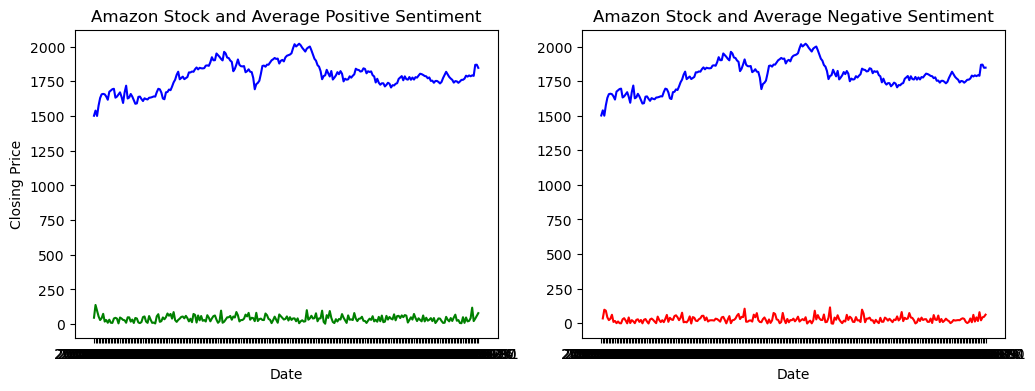

In [17]:
# comparing trend of stock to trend of positive and negative sentiment over the year
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(stock_data[0].iloc[1:]['Date'], lag_data[0]['prev_close'], color='b')
ax1.plot(stock_data[0].iloc[1:]['Date'], lag_data[0]['pos_sentiment'], color='g')
ax1.set(xlabel='Date',
       ylabel='Closing Price',
       title='Amazon Stock and Average Positive Sentiment')
ax2.plot(stock_data[0]['Date'], stock_data[0]['Close'], color='b')
ax2.plot(stock_data[0].iloc[1:]['Date'], lag_data[0]['neg_sentiment'], color='r')
ax2.set(xlabel='Date',
       title='Amazon Stock and Average Negative Sentiment')